#  Implémentation d'un réseau de neurones multiclasses pour la classification des caractères Tifinagh générés à partir de la base de données AMHCD.

In [1]:
import pandas as pd

In [13]:
import pandas as pd

# Lire la liste des caractères tifinagh
with open(r'C:\Users\ADMIN_SB\Desktop\master IAA\S2\Deep Learning\TP5.2\archive\labels\labels\sorted-33-common-tifinagh.txt', 'r', encoding='utf-8') as f:
    caracteres = [ligne.strip() for ligne in f]

# Associer chaque dossier (ex: "ya", "yab", ...) à son caractère réel
label_map = {f"y{''.join(filter(str.isalpha, c))}": c for c in caracteres}

caracteres


['ⴰ',
 'ⴱ',
 'ⵛ',
 'ⴷ',
 'ⴹ',
 'ⵄ',
 'ⴼ',
 'ⴳ',
 'ⵖ',
 'ⴳⵯ',
 'ⵀ',
 'ⵃ',
 'ⵊ',
 'ⴽ',
 'ⴽⵯ',
 'ⵍ',
 'ⵎ',
 'ⵏ',
 'ⵇ',
 'ⵔ',
 'ⵕ',
 'ⵙ',
 'ⵚ',
 'ⵜ',
 'ⵟ',
 'ⵡ',
 'ⵅ',
 'ⵢ',
 'ⵣ',
 'ⵥ',
 'ⴻ',
 'ⵉ',
 'ⵓ']

In [34]:
# Test de lecture réelle d'image
test_path = r'C:\Users\ADMIN_SB\Desktop\master IAA\S2\Deep Learning\TP5.2\archive\AMHCD_64\AMHCD_64\yu\yu_1.jpeg'

from PIL import Image
import numpy as np

try:
    img = Image.open(test_path).convert('RGB')
    img = img.resize((64, 64))
    img_np = np.array(img)
    print("✅ Image shape:", img_np.shape)  # Devrait afficher (64, 64, 3)
    print("✅ Image flattened:", img_np.reshape(-1).shape)  # Devrait afficher (12288,)
except Exception as e:
    print("❌ Erreur de lecture:", e)


✅ Image shape: (64, 64, 3)
✅ Image flattened: (12288,)


In [37]:
from PIL import Image
import numpy as np
import os

# Charger caractères
with open(r'C:\Users\ADMIN_SB\Desktop\master IAA\S2\Deep Learning\TP5.2\archive\labels\labels\sorted-33-common-tifinagh.txt', 'r', encoding='utf-8') as f:
    caracteres = [ligne.strip() for ligne in f]

# Dossier racine
root_dir = r'C:\Users\ADMIN_SB\Desktop\master IAA\S2\Deep Learning\TP5.2\archive\AMHCD_64\AMHCD_64'

X = []
y = []

# Sous-dossiers triés
sous_dossiers = sorted(os.listdir(root_dir))  # ordre alphabétique == ordre du .txt
print("🔢 Nombre de classes trouvées :", len(sous_dossiers))

for label_index, subfolder in enumerate(sous_dossiers):
    subfolder_path = os.path.join(root_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for filename in os.listdir(subfolder_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_path = os.path.join(subfolder_path, filename)
                try:
                    with Image.open(image_path) as img:
                        img = img.convert('RGB')
                        img = img.resize((64, 64))
                        img_vector = np.array(img).reshape(-1) / 255.0
                        X.append(img_vector)
                        y.append(label_index)
                except Exception as e:
                    print(f"Erreur image {filename} :", e)

X = np.array(X)
y = np.array(y)

print("✅ X shape:", X.shape)
print("✅ y shape:", y.shape)


🔢 Nombre de classes trouvées : 33
✅ X shape: (25740, 12288)
✅ y shape: (25740,)


In [17]:
#encodage

In [39]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
Y = encoder.fit_transform(y.reshape(-1, 1))  # Y.shape = (25740, 33)


In [40]:
#split

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [52]:
X_train

array([[1.        , 1.        , 0.98039216, ..., 0.96470588, 0.99607843,
        1.        ],
       [0.99607843, 0.99607843, 0.99607843, ..., 1.        , 1.        ,
        1.        ],
       [0.99607843, 0.99607843, 0.98823529, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 0.97254902, ..., 1.        , 1.        ,
        0.99215686],
       [0.97647059, 1.        , 0.98039216, ..., 0.70980392, 0.74509804,
        0.80392157],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

# Définition de la fonction softmax

In [53]:
def softmax(x):
    """
    Softmax activation function.
    Transforme un vecteur de scores (logits) en probabilités.
    Appliquée généralement à la sortie d’un réseau pour classification multiclasse.
    """
    assert isinstance(x, np.ndarray), "Input to softmax must be a numpy array"
    
    # stabilité numérique : on soustrait le max pour éviter overflow
    shift_x = x - np.max(x, axis=-1, keepdims=True)
    exps = np.exp(shift_x)
    sums = np.sum(exps, axis=-1, keepdims=True)
    result = exps / sums

    # Assertion : chaque ligne doit former une distribution de probabilité (somme = 1)
    assert np.allclose(np.sum(result, axis=-1), 1.0, atol=1e-6), "Softmax output must sum to 1 along classes"
    
    return result


# Définition de la dérivée de softmax (Jacobian vectorisé simplifié pour backward)

In [54]:
def softmax_derivative(softmax_output):
    """
    Simplified derivative of softmax.
    Cette version retourne une dérivée diagonale utile si on enchaîne avec la loss cross-entropy.
    
    ⚠️ Ce n’est pas le Jacobian complet, mais suffisant pour le backprop avec cross-entropy.
    """
    assert isinstance(softmax_output, np.ndarray), "Input must be a numpy array"
    assert np.all((softmax_output >= 0) & (softmax_output <= 1)), "Softmax values must be in [0, 1]"
    
    return softmax_output * (1 - softmax_output)  # valable si utilisé seul sans cross-entropy


# Jacobian complet (optionnel)

In [55]:
def softmax_jacobian(s):
    """
    Jacobian matrix of the softmax function for un vecteur `s` = softmax(x)
    """
    assert len(s.shape) == 1, "Input must be a 1D vector"
    s = s.reshape(-1, 1)
    jacobian = np.diagflat(s) - np.dot(s, s.T)
    return jacobian


# code

In [56]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Fonctions d’activation
# -------------------------------

def relu(x):
    """
    ReLU activation : max(0, x)
    """
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    """
    Derivative of ReLU: 1 if x > 0, else 0
    """
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = np.where(x > 0, 1, 0)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def sigmoid(x):
    """
    Sigmoid activation : 1 / (1 + exp(-x))
    """
    assert isinstance(x, np.ndarray), "Input to sigmoid must be a numpy array"
    result = 1 / (1 + np.exp(-x))
    assert np.all((result >= 0) & (result <= 1)), "Sigmoid output must be in [0, 1]"
    return result

def sigmoid_derivative(x):
    """
    Derivative of sigmoid: sigmoid(x) * (1 - sigmoid(x))
    """
    assert isinstance(x, np.ndarray), "Input to sigmoid derivative must be a numpy array"
    s = sigmoid(x)
    result = s * (1 - s)
    assert np.all((result >= 0) & (result <= 0.25)), "Sigmoid derivative must be in [0, 0.25]"
    return result


In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, l2_lambda=0.0):
        """
        Initialize the neural network with given layer sizes and learning rate.
        layer_sizes : list of int [input_size, hidden1_size, ..., output_size]
        learning_rate : float
        l2_lambda : float, coefficient for L2 regularization
        """
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be positive"
        assert isinstance(l2_lambda, (int, float)) and l2_lambda >= 0, "L2 regularization must be non-negative"

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda

        self.weights = []
        self.biases = []

        np.random.seed(42)
        # Initialize weights with Xavier initialization and biases with zeros
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i + 1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i + 1]), f"Weight matrix {i + 1} has incorrect shape"
            assert b.shape == (1, layer_sizes[i + 1]), f"Bias vector {i + 1} has incorrect shape"
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        """
        Forward propagation:
        Z^{[l]} = A^{[l-1]} W^{[l]} + b^{[l]}
        A^{[l]} = g(Z^{[l]}) with sigmoid activation
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        self.activations = [X]
        self.z_values = []

        for i in range(len(self.weights)):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i + 1]), f"Z^{i + 1} has incorrect shape"
            self.z_values.append(z)
            #a = sigmoid(z)
            if i == len(self.weights) - 1:
                a = softmax(z)  # sortie finale
            else:
                a = relu(z)

            self.activations.append(a)

        assert self.activations[-1].shape == (X.shape[0], self.layer_sizes[-1]), "Output activation has incorrect shape"
        return self.activations[-1]
   

    def compute_loss(self, y_true, y_pred) :
        m = y_true.shape[0]
        epsilon = 1e-8
        loss = -np.sum(y_true * np.log(y_pred + epsilon)) / m
        # L2 regularization
        if self.l2_lambda > 0:
            l2_loss = 0.5 * self.l2_lambda * sum(np.sum(w ** 2) for w in self.weights)
            loss += l2_loss / m
        return loss


    def compute_accuracy(self, y_true, y_pred):
        """
        Compute accuracy : proportion of correct predictions
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        preds = np.argmax(y_pred, axis=1)
        true = np.argmax(y_true, axis=1)
        accuracy = np.mean(preds == true)

        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self, X, y, outputs):
        """
        Backpropagation : compute gradients dW^{[l]}, db^{[l]} for each layer
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"

        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]

        # Output layer error
        dZ = outputs - y
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"

        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        # Backpropagate through hidden layers
        for i in range(len(self.weights) - 2, -1, -1):
            dA = dZ @ self.weights[i + 1].T
            #dZ = dA * sigmoid_derivative(self.activations[i + 1])
            dZ = dA * relu_derivative(self.z_values[i])

            assert dZ.shape == (m, self.layer_sizes[i + 1]), f"dZ at layer {i + 1} has incorrect shape"
            self.d_weights[i] = (self.activations[i].T @ dZ) / m

            # Add L2 regularization to weight gradients
            if self.l2_lambda > 0:
                self.d_weights[i] += (self.l2_lambda / m) * self.weights[i]

            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m

        # Update weights and biases using gradient descent
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.d_weights[i]
            self.biases[i] -= self.learning_rate * self.d_biases[i]

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        """
        Train the neural network using mini-batch SGD, with validation
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)

            train_loss = epoch_loss / (X.shape[0] / batch_size)

            # Validation loss and accuracy
            val_outputs = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_outputs)

            train_accuracy = self.compute_accuracy(y, self.forward(X))
            val_accuracy = self.compute_accuracy(y_val, val_outputs)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        """
        Predict class labels (0 or 1)
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        outputs = self.forward(X)
        predictions = (outputs >= 0.5).astype(int)
        assert predictions.shape == (X.shape[0], self.layer_sizes[-1]), "Predictions have incorrect shape"
        return predictions

"""
    # Adagrad
    def train_adagrad(X, y, lr=0.01, epochs=1000, epsilon=1e-8):
        np.random.seed(0)
        n_samples, n_features = X.shape
        W1 = np.random.randn(n_features, 10)
        b1 = np.zeros(10)
        W2 = np.random.randn(10, 1)
        b2 = 0
        G_W1 = np.zeros_like(W1)
        G_b1 = np.zeros_like(b1)
        G_W2 = np.zeros_like(W2)
        G_b2 = 0
        losses = []
        for epoch in range(epochs):
            Z1 = X.dot(W1) + b1
            A1 = relu(Z1)
            Z2 = A1.dot(W2) + b2
            A2 = sigmoid(Z2).flatten()
            loss = binary_cross_entropy(y, A2)
            losses.append(loss)
            dZ2 = A2 - y
            dW2 = A1.T.dot(dZ2[:, None]) / n_samples
            db2 = np.mean(dZ2)
            dA1 = dZ2[:, None].dot(W2.T)
            dZ1 = dA1 * relu_derivative(Z1)
            dW1 = X.T.dot(dZ1) / n_samples
            db1 = np.mean(dZ1, axis=0)
            G_W1 += dW1**2
            G_b1 += db1**2
            G_W2 += dW2**2
            G_b2 += db2**2
            W1 -= lr * dW1 / (np.sqrt(G_W1) + epsilon)
            b1 -= lr * db1 / (np.sqrt(G_b1) + epsilon)
            W2 -= lr * dW2 / (np.sqrt(G_W2) + epsilon)
            b2 -= lr * db2 / (np.sqrt(G_b2) + epsilon)
        return W1, b1, W2, b2,losses
"""
# Exemple d'utilisation avec le dataset diabetes.csv
"""
# Charger et préparer les données
data = df.copy()

# Séparer les features et la cible
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1, 1)

assert X.shape[0] == y.shape[0], "Number of samples in X and y must match"
assert X.shape[1] == 8, "Expected 8 features in input data"

# Standardisation : (X - mu) / sigma
mu = X.mean(axis=0)
sigma = X.std(axis=0)
X = (X - mu) / sigma

# Diviser les données en train, validation et test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)  # 0.25 x 0.8 = 0.2

assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0], "Train-val-test split sizes must sum to total samples"

"""

'\n# Charger et préparer les données\ndata = df.copy()\n\n# Séparer les features et la cible\nX = data.iloc[:, :-1].values\ny = data.iloc[:, -1].values.reshape(-1, 1)\n\nassert X.shape[0] == y.shape[0], "Number of samples in X and y must match"\nassert X.shape[1] == 8, "Expected 8 features in input data"\n\n# Standardisation : (X - mu) / sigma\nmu = X.mean(axis=0)\nsigma = X.std(axis=0)\nX = (X - mu) / sigma\n\n# Diviser les données en train, validation et test\nX_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)  # 0.25 x 0.8 = 0.2\n\nassert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0], "Train-val-test split sizes must sum to total samples"\n\n'

# entrainement avec learning rate 0.01 et GD

In [ ]:
# Créer et entraîner le modèle ... learning rate 0.01
input_size = 64 * 64 * 3  # 4096
hidden1 = 256
hidden2 = 128
output_size = 33

nn = NeuralNetwork([input_size, hidden1, hidden2, output_size], learning_rate=0.01)
"""
layer_sizes = [X_train.shape[1], 16, 8, 1]
nn = NeuralNetwork(layer_sizes, learning_rate=0.01, l2_lambda=0.001)"""

train_losses, val_losses, train_accuracies, val_accuracies = nn.train(X_train, y_train, X_test, y_test, epochs=100, batch_size=32)

# Prédictions et évaluation
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set) :")
print(classification_report(y_test, y_pred))


Epoch 0, Train Loss: 3.5103, Val Loss: 3.4965, Train Acc: 0.0309, Val Acc: 0.0305
Epoch 10, Train Loss: 3.0012, Val Loss: 2.9211, Train Acc: 0.0933, Val Acc: 0.0890


In [106]:
# Adagrad
def train_adagrad(X, y, lr=0.01, epochs=1000, epsilon=1e-8):
    np.random.seed(0)
    n_samples, n_features = X.shape
    W1 = np.random.randn(n_features, 10)
    b1 = np.zeros(10)
    W2 = np.random.randn(10, 1)
    b2 = 0
    G_W1 = np.zeros_like(W1)
    G_b1 = np.zeros_like(b1)
    G_W2 = np.zeros_like(W2)
    G_b2 = 0
    losses = []
    for epoch in range(epochs):
        Z1 = X.dot(W1) + b1
        A1 = relu(Z1)
        Z2 = A1.dot(W2) + b2
        A2 = sigmoid(Z2).flatten()
        loss = binary_cross_entropy(y, A2)
        losses.append(loss)
        dZ2 = A2 - y
        dW2 = A1.T.dot(dZ2[:, None]) / n_samples
        db2 = np.mean(dZ2)
        dA1 = dZ2[:, None].dot(W2.T)
        dZ1 = dA1 * relu_derivative(Z1)
        dW1 = X.T.dot(dZ1) / n_samples
        db1 = np.mean(dZ1, axis=0)
        G_W1 += dW1**2
        G_b1 += db1**2
        G_W2 += dW2**2
        G_b2 += db2**2
        W1 -= lr * dW1 / (np.sqrt(G_W1) + epsilon)
        b1 -= lr * db1 / (np.sqrt(G_b1) + epsilon)
        W2 -= lr * dW2 / (np.sqrt(G_W2) + epsilon)
        b2 -= lr * db2 / (np.sqrt(G_b2) + epsilon)
    return W1, b1, W2, b2,losses


# entrainement avec la fonction de perte adagrad

In [109]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Fonctions d'activation
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # stabilité numérique
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Classe MLP
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, l2_lambda=0.0):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.weights = []
        self.biases = []

        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights)):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            if i == len(self.weights) - 1:
                a = softmax(z)
            else:
                a = relu(z)
            self.activations.append(a)
        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        epsilon = 1e-8
        loss = -np.sum(y_true * np.log(y_pred + epsilon)) / m
        if self.l2_lambda > 0:
            l2_loss = 0.5 * self.l2_lambda * sum(np.sum(w ** 2) for w in self.weights)
            loss += l2_loss / m
        return loss

    def compute_accuracy(self, y_true, y_pred):
        preds = np.argmax(y_pred, axis=1)
        true = np.argmax(y_true, axis=1)
        return np.mean(preds == true)

    def backward(self, X, y, outputs):
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]

        dZ = outputs - y
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        for i in range(len(self.weights) - 2, -1, -1):
            dA = dZ @ self.weights[i + 1].T
            dZ = dA * relu_derivative(self.z_values[i])
            self.d_weights[i] = (self.activations[i].T @ dZ) / m
            if self.l2_lambda > 0:
                self.d_weights[i] += (self.l2_lambda / m) * self.weights[i]
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m

    def train_adagrad(self, X, y, X_val, y_val, epochs=100, batch_size=32, epsilon=1e-8):
        G_w = [np.zeros_like(w) for w in self.weights]
        G_b = [np.zeros_like(b) for b in self.biases]

        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled, y_shuffled = X[indices], y[indices]
            epoch_loss = 0

            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                outputs = self.forward(X_batch)
                loss = self.compute_loss(y_batch, outputs)
                epoch_loss += loss

                self.backward(X_batch, y_batch, outputs)

                for j in range(len(self.weights)):
                    G_w[j] += self.d_weights[j] ** 2
                    G_b[j] += self.d_biases[j] ** 2

                    self.weights[j] -= (self.learning_rate / (np.sqrt(G_w[j]) + epsilon)) * self.d_weights[j]
                    self.biases[j] -= (self.learning_rate / (np.sqrt(G_b[j]) + epsilon)) * self.d_biases[j]

            train_loss = epoch_loss / (X.shape[0] / batch_size)
            val_outputs = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_outputs)
            train_acc = self.compute_accuracy(y, self.forward(X))
            val_acc = self.compute_accuracy(y_val, val_outputs)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            if epoch % 10 == 0:
                print(f"[Adagrad] Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        outputs = self.forward(X)
        return np.argmax(outputs, axis=1)

# Préparation des données (à adapter si besoin)
# X : (n_samples, 4096), y : (n_samples,) avec étiquettes entières de 0 à 32

# One-hot encode y
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Split train/val/test
X_temp, X_test, y_temp, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp.argmax(1), random_state=42)

# Initialisation et entraînement
model = NeuralNetwork(layer_sizes=[4096, 256, 128, 33], learning_rate=0.01)
train_losses, val_losses, train_accuracies, val_accuracies = model.train_adagrad(X_train, y_train, X_val, y_val, epochs=100, batch_size=32)

# Évaluation
y_pred = model.predict(X_test)
y_true = y_test.argmax(1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("\nMatrice de confusion:")
print(confusion_matrix(y_true, y_pred))


[Adagrad] Epoch 0, Train Loss: 1.2669, Val Loss: 0.7883, Train Acc: 0.7954, Val Acc: 0.7534
[Adagrad] Epoch 10, Train Loss: 0.0559, Val Loss: 0.1814, Train Acc: 0.9944, Val Acc: 0.9422
[Adagrad] Epoch 20, Train Loss: 0.0186, Val Loss: 0.1446, Train Acc: 0.9996, Val Acc: 0.9505
[Adagrad] Epoch 30, Train Loss: 0.0096, Val Loss: 0.1394, Train Acc: 1.0000, Val Acc: 0.9521
[Adagrad] Epoch 40, Train Loss: 0.0061, Val Loss: 0.1373, Train Acc: 1.0000, Val Acc: 0.9523
[Adagrad] Epoch 50, Train Loss: 0.0043, Val Loss: 0.1358, Train Acc: 1.0000, Val Acc: 0.9544
[Adagrad] Epoch 60, Train Loss: 0.0033, Val Loss: 0.1337, Train Acc: 1.0000, Val Acc: 0.9549
[Adagrad] Epoch 70, Train Loss: 0.0026, Val Loss: 0.1339, Train Acc: 1.0000, Val Acc: 0.9555
[Adagrad] Epoch 80, Train Loss: 0.0022, Val Loss: 0.1340, Train Acc: 1.0000, Val Acc: 0.9565
[Adagrad] Epoch 90, Train Loss: 0.0019, Val Loss: 0.1340, Train Acc: 1.0000, Val Acc: 0.9564

Classification Report:
              precision    recall  f1-score   s

# entrainement avec la fonction de perte adam


[Adam] Epoch 10, Train Loss: 0.0598, Val Loss: 0.1911, Train Acc: 0.9934, Val Acc: 0.9375
[Adam] Epoch 20, Train Loss: 0.0166, Val Loss: 0.1559, Train Acc: 0.9982, Val Acc: 0.9521
[Adam] Epoch 30, Train Loss: 0.0054, Val Loss: 0.1418, Train Acc: 0.9998, Val Acc: 0.9578
[Adam] Epoch 40, Train Loss: 0.0026, Val Loss: 0.1384, Train Acc: 1.0000, Val Acc: 0.9581
[Adam] Epoch 50, Train Loss: 0.0328, Val Loss: 0.2642, Train Acc: 0.9907, Val Acc: 0.9347
[Adam] Epoch 60, Train Loss: 0.0012, Val Loss: 0.1394, Train Acc: 1.0000, Val Acc: 0.9606
[Adam] Epoch 70, Train Loss: 0.0043, Val Loss: 0.1592, Train Acc: 1.0000, Val Acc: 0.9574
[Adam] Epoch 80, Train Loss: 0.0002, Val Loss: 0.1440, Train Acc: 1.0000, Val Acc: 0.9611
[Adam] Epoch 90, Train Loss: 0.0010, Val Loss: 0.1507, Train Acc: 1.0000, Val Acc: 0.9571
[Adam] Epoch 100, Train Loss: 0.0612, Val Loss: 0.2155, Train Acc: 0.9952, Val Acc: 0.9487

✅ Meilleure validation accuracy : 0.9626


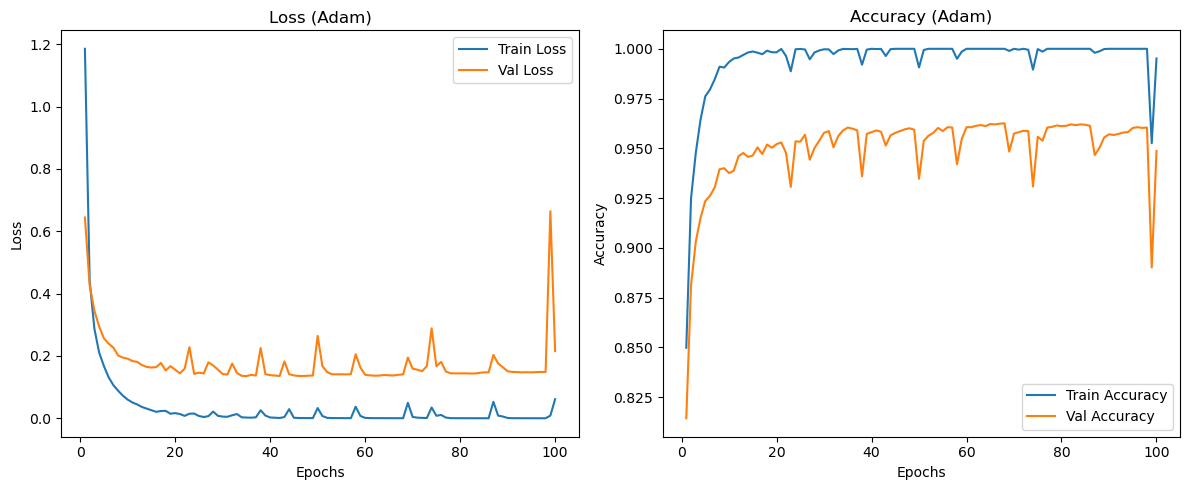


✅ Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       170
           1       0.94      0.90      0.92       171
           2       0.96      0.98      0.97       171
           3       0.98      0.99      0.99       171
           4       0.99      0.97      0.98       171
           5       0.92      0.88      0.90       171
           6       0.95      0.92      0.93       171
           7       0.97      0.99      0.98       171
           8       0.95      0.95      0.95       171
           9       0.98      0.98      0.98       170
          10       0.96      0.98      0.97       171
          11       0.97      0.98      0.97       171
          12       0.99      0.98      0.99       171
          13       0.99      0.98      0.99       171
          14       0.96      0.96      0.96       171
          15       0.91      0.92      0.92       171
          16       0.95      0.93      0.94       170
 

In [110]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Fonctions d'activation
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Classe MLP avec Adam
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.001, l2_lambda=0.0):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.weights = []
        self.biases = []
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights)):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            a = softmax(z) if i == len(self.weights) - 1 else relu(z)
            self.activations.append(a)
        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        epsilon = 1e-8
        loss = -np.sum(y_true * np.log(y_pred + epsilon)) / m
        if self.l2_lambda > 0:
            l2 = 0.5 * self.l2_lambda * sum(np.sum(w ** 2) for w in self.weights)
            loss += l2 / m
        return loss

    def compute_accuracy(self, y_true, y_pred):
        return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))

    def backward(self, X, y, outputs):
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        dZ = outputs - y
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in range(len(self.weights) - 2, -1, -1):
            dA = dZ @ self.weights[i + 1].T
            dZ = dA * relu_derivative(self.z_values[i])
            self.d_weights[i] = (self.activations[i].T @ dZ) / m
            if self.l2_lambda > 0:
                self.d_weights[i] += (self.l2_lambda / m) * self.weights[i]
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m

    def train_adam(self, X, y, X_val, y_val, epochs=100, batch_size=32, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        m_w = [np.zeros_like(w) for w in self.weights]
        v_w = [np.zeros_like(w) for w in self.weights]
        m_b = [np.zeros_like(b) for b in self.biases]
        v_b = [np.zeros_like(b) for b in self.biases]

        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
        best_val_acc = 0

        for epoch in range(1, epochs + 1):
            indices = np.random.permutation(X.shape[0])
            X_shuffled, y_shuffled = X[indices], y[indices]
            epoch_loss = 0

            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)

                for j in range(len(self.weights)):
                    m_w[j] = beta1 * m_w[j] + (1 - beta1) * self.d_weights[j]
                    v_w[j] = beta2 * v_w[j] + (1 - beta2) * (self.d_weights[j] ** 2)
                    m_b[j] = beta1 * m_b[j] + (1 - beta1) * self.d_biases[j]
                    v_b[j] = beta2 * v_b[j] + (1 - beta2) * (self.d_biases[j] ** 2)
                    m_w_corr = m_w[j] / (1 - beta1 ** epoch)
                    v_w_corr = v_w[j] / (1 - beta2 ** epoch)
                    m_b_corr = m_b[j] / (1 - beta1 ** epoch)
                    v_b_corr = v_b[j] / (1 - beta2 ** epoch)
                    self.weights[j] -= lr * m_w_corr / (np.sqrt(v_w_corr) + epsilon)
                    self.biases[j] -= lr * m_b_corr / (np.sqrt(v_b_corr) + epsilon)

            train_loss = epoch_loss / (X.shape[0] / batch_size)
            val_outputs = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_outputs)
            train_acc = self.compute_accuracy(y, self.forward(X))
            val_acc = self.compute_accuracy(y_val, val_outputs)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_weights = [w.copy() for w in self.weights]
                best_biases = [b.copy() for b in self.biases]

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            if epoch % 10 == 0:
                print(f"[Adam] Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        self.weights = best_weights
        self.biases = best_biases
        print(f"\n✅ Meilleure validation accuracy : {best_val_acc:.4f}")
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

# Visualisation
def plot_training(train_losses, val_losses, train_accuracies, val_accuracies, title=""):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss {title}')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy {title}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === PRÉPARATION DES DONNÉES ===
# Supposons que X (n_samples, 4096) et y (n_samples,) sont déjà chargés

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Split
X_temp, X_test, y_temp, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp.argmax(1), random_state=42)

# === ENTRAÎNEMENT ===
model = NeuralNetwork(layer_sizes=[4096, 256, 128, 33], learning_rate=0.001)
train_losses, val_losses, train_accuracies, val_accuracies = model.train_adam(
    X_train, y_train, X_val, y_val, epochs=100, batch_size=32
)

# === VISUALISATION ===
plot_training(train_losses, val_losses, train_accuracies, val_accuracies, title="(Adam)")

# === ÉVALUATION FINALE ===
y_pred = model.predict(X_test)
y_true = y_test.argmax(1)

print("\n✅ Classification Report:")
print(classification_report(y_true, y_pred))
print("\n📊 Matrice de confusion:")
print(confusion_matrix(y_true, y_pred))
